In [2]:
# ============================================================
# CSINet-test (baseline, no adapters)
# ------------------------------------------------------------
# - Evaluates multiple CSINet variants:
#       indoor
#       outdoor
#       indoor+outdoor   (joint model, but still tested on indoor / outdoor separately)
#       finetune_in2out
#       finetune_out2in
#       replay_in2out
#       replay_out2in
#
# - Test scenarios (columns): Indoor, Outdoor
# - Writes NMSE (angle–delay) to: results/nmse_results.csv
# - Saves example heatmaps for |H| (orig vs recon)
# ============================================================

from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import os

# ============================================================
# CONFIG
# ============================================================

dst_path    = "./dataset"     # where DATA_Htestin.mat and DATA_Htestout.mat are
ckpt_dir    = "checkpoints"   # directory with trained CSINet checkpoints
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ------------------------------------------------------------
# Model types (rows in CSV)
# ------------------------------------------------------------
MODEL_TYPES = [
    "indoor",
    "outdoor",
    "indoor+outdoor",
    "finetune_in2out",
    "finetune_out2in",
    "replay_in2out",
    "replay_out2in",
]

# Test scenarios (columns in CSV) – ONLY indoor & outdoor
SCENARIO_TYPES = ["indoor", "outdoor"]

# Base hyper-parameters (must match training)
batch_size    = 200
encoded_dim   = 512           # adjust if CSINet uses another compression
residual_num  = 2             # number of residual blocks in decoder
base_channels = 8             # capacity of residual blocks

# ------------------------------------------------------------
# Map model_type → checkpoint filename
# Adapt these names to match what is saved in training.
# ------------------------------------------------------------
CKPT_MAP = {
    "indoor":           "csinet_best_indoor.pt",
    "outdoor":          "csinet_best_outdoor.pt",
    "indoor+outdoor":   "csinet_best_indoor+outdoor.pt",
    "finetune_in2out":  "csinet_best_finetune_in2out.pt",
    "finetune_out2in":  "csinet_best_finetune_out2in.pt",
    "replay_in2out":    "csinet_best_replay_in2out.pt",
    "replay_out2in":    "csinet_best_replay_out2in.pt",
}

Device: cpu


In [3]:
# ============================================================
# 0. GLOBAL CONSTANTS & BASELINE CSINet ARCHITECTURE
# ============================================================

img_height = 32
img_width = 32
img_channels = 2
img_total = img_height * img_width * img_channels

class ResidualBlockDecoded(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 2, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(2)
        self.act   = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        shortcut = x
        y = self.act(self.bn1(self.conv1(x)))
        y = self.act(self.bn2(self.conv2(y)))
        y = self.bn3(self.conv3(y))
        y = self.act(shortcut + y)
        return y

class CsiNet(nn.Module):
    def __init__(self, encoded_dim=512, residual_num=2):
        super().__init__()
        self.encoded_dim = encoded_dim
        self.residual_num = residual_num

        # first conv
        self.conv_in = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.bn_in   = nn.BatchNorm2d(2)
        self.act     = nn.LeakyReLU(inplace=True)

        # encoder dense
        self.fc_enc  = nn.Linear(img_total, encoded_dim)

        # decoder dense
        self.fc_dec  = nn.Linear(encoded_dim, img_total)

        # residual blocks
        self.res_blocks = nn.ModuleList([ResidualBlockDecoded() for _ in range(residual_num)])

        # final conv + sigmoid
        self.conv_out = nn.Conv2d(2, 2, kernel_size=3, padding=1)
        self.sigmoid  = nn.Sigmoid()

    def forward(self, x):
        # x: (B, 2, 32, 32)
        x = self.act(self.bn_in(self.conv_in(x)))
        # flatten
        B = x.size(0)
        x = x.view(B, -1)              # (B, img_total)
        encoded = self.fc_enc(x)       # (B, encoded_dim)

        x = self.fc_dec(encoded)       # (B, img_total)
        x = x.view(B, img_channels, img_height, img_width)
        for block in self.res_blocks:
            x = block(x)

        x = self.sigmoid(self.conv_out(x))  # (B, 2, 32, 32), in [0,1]
        return x, encoded  # return encoded if you want bottleneck too


In [4]:
# ============================================================
# 1. DATA LOADING & METRICS
# ============================================================

def load_single_domain(kind: str) -> np.ndarray:
    """
    kind: 'indoor' or 'outdoor'
    Returns X with shape (N, 2, 32, 32) as float32.
    Assumes HT in the .mat is 2-D flattened: (N, img_total) or (img_total, N).
    """
    if kind == "indoor":
        mat_path = os.path.join(dst_path, "DATA_Htestin.mat")
    elif kind == "outdoor":
        mat_path = os.path.join(dst_path, "DATA_Htestout.mat")
    else:
        raise ValueError("kind must be 'indoor' or 'outdoor'")

    mat = sio.loadmat(mat_path)
    H = mat["HT"]  # 2-D

    if H.ndim != 2:
        raise ValueError(f"Unexpected HT.ndim={H.ndim}, expected 2")

    n1, n2 = H.shape
    if n2 == img_total:
        X = H.reshape(-1, img_channels, img_height, img_width)
    elif n1 == img_total:
        X = H.T.reshape(-1, img_channels, img_height, img_width)
    else:
        raise ValueError(
            f"Cannot infer shape from HT with shape {H.shape}; "
            f"neither dimension equals img_total={img_total}"
        )

    X = X.astype(np.float32)
    print(f"Loaded {kind} test data:", X.shape)
    return X


def nmse_angle_delay_db(X: np.ndarray, X_hat: np.ndarray) -> float:
    """
    X, X_hat: (N, 2, 32, 32), values in [0,1].
    Uses original CSINet normalization:
        h = (real-0.5) + j*(imag-0.5)
    Returns NMSE in dB in angle–delay domain.
    """
    N = X.shape[0]

    x_real = X[:, 0, :, :].reshape(N, -1)
    x_imag = X[:, 1, :, :].reshape(N, -1)
    x_cmplx = x_real - 0.5 + 1j * (x_imag - 0.5)

    y_real = X_hat[:, 0, :, :].reshape(N, -1)
    y_imag = X_hat[:, 1, :, :].reshape(N, -1)
    y_cmplx = y_real - 0.5 + 1j * (y_imag - 0.5)

    power = np.sum(np.abs(x_cmplx) ** 2, axis=1)
    mse   = np.sum(np.abs(x_cmplx - y_cmplx) ** 2, axis=1)
    nmse  = np.mean(mse / power)
    nmse_db = 10 * np.log10(nmse)
    return float(nmse_db)


def test_label(name: str) -> str:
    """Pretty column label for CSV."""
    name = name.lower()
    if "indoor+outdoor" in name or "indoor_outdoor" in name:
        return "Indoor + Outdoor"
    elif "indoor" in name:
        return "Indoor"
    elif "outdoor" in name:
        return "Outdoor"
    else:
        return name.capitalize()


In [5]:
# ============================================================
# 2. EVALUATION FUNCTION FOR BASELINE CSINet
# ============================================================

def eval_csinet(model_type: str, scenario_type: str):
    """
    Evaluate one CSINet variant (model_type) on one test scenario (scenario_type).

    model_type:
        indoor, outdoor, indoor+outdoor,
        finetune_in2out, finetune_out2in,
        replay_in2out, replay_out2in

    scenario_type:
        'indoor' or 'outdoor'

    Note:
      - 'indoor+outdoor' here is ONLY a model type (jointly trained).
      - It is still evaluated on indoor / outdoor test sets separately.
    """

    print("\n" + "="*60)
    print(f"[EVAL] CSINet baseline")
    print(f"       model_type   = {model_type}")
    print(f"       scenario     = {scenario_type}")
    print("="*60)

    # ----------------- 1. Load test data -----------------
    if scenario_type in ["indoor", "outdoor"]:
        X = load_single_domain(scenario_type)
    else:
        raise ValueError(f"Unknown scenario_type: {scenario_type}")

    x_t = torch.from_numpy(X).float().to(device)

    # ----------------- 2. Build model & load checkpoint -----------------
    model = CsiNet(encoded_dim=512, residual_num=2).to(device)

    ckpt_name = CKPT_MAP[model_type]
    ckpt_path = os.path.join(ckpt_dir, ckpt_name)
    print("[Load] checkpoint:", ckpt_path)

    checkpoint = torch.load(ckpt_path, map_location=device)

    # Be robust to different saving formats
    if isinstance(checkpoint, dict):
        if "model_state_dict" in checkpoint:
            model.load_state_dict(checkpoint["model_state_dict"])
        elif "state_dict" in checkpoint:
            model.load_state_dict(checkpoint["state_dict"])
        elif "encoder_state_dict" in checkpoint and "decoder_state_dict" in checkpoint:
            model.encoder.load_state_dict(checkpoint["encoder_state_dict"])
            model.decoder.load_state_dict(checkpoint["decoder_state_dict"])
        else:
            # maybe you saved plain state_dict
            model.load_state_dict(checkpoint)
    else:
        # checkpoint is state_dict
        model.load_state_dict(checkpoint)

    model.eval()

    # ----------------- 3. Forward pass -----------------
    with torch.no_grad():
        X_hat_t, _ = model(x_t)   # X_hat_t is now the reconstruction tensor
        X_hat = X_hat_t.cpu().numpy()       # or X_hat_t.cpu().numpy() if using GPU

    X_hat = X_hat_t.cpu().numpy()

    # ----------------- 4. NMSE computation -----------------
    nmse_db = nmse_angle_delay_db(X, X_hat)
    print(f"[RESULT] NMSE (angle–delay) = {nmse_db:.2f} dB")

    # ----------------- 5. Update CSV -----------------
    csv_path = os.path.join(results_dir, "nmse_results.csv")
    col_label = test_label(scenario_type)   # "Indoor" / "Outdoor"
    row_label = model_type                  # e.g. "indoor", "replay_in2out", ...

    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path, index_col=0)
    else:
        df = pd.DataFrame()

    if col_label not in df.columns:
        df[col_label] = np.nan
    if row_label not in df.index:
        df.loc[row_label] = np.nan

    df.loc[row_label, col_label] = nmse_db
    df.to_csv(csv_path)

    print("[CSV] Updated:")
    print(df)

    # ----------------- 6. Heatmap comparison -----------------
    # Use X (original) and X_hat (reconstructed) we already have.
    n_show = min(6, X.shape[0])
    idxs = np.arange(n_show)  # or np.random.choice(X.shape[0], n_show, replace=False)

    plt.figure(figsize=(2*n_show, 4))

    for i, idx in enumerate(idxs):
        # Original magnitude in angle–delay
        H_orig = np.abs(
            X[idx, 0, :, :] - 0.5 + 1j * (X[idx, 1, :, :] - 0.5)
        )
        # Reconstructed magnitude
        H_rec = np.abs(
            X_hat[idx, 0, :, :] - 0.5 + 1j * (X_hat[idx, 1, :, :] - 0.5)
        )

        # ORIGINAL
        ax = plt.subplot(2, n_show, i + 1)
        plt.imshow(H_orig.T, origin="lower", aspect="auto")
        plt.title(f"Orig #{idx}")
        plt.xlabel("Angle index")
        plt.ylabel("Delay index")
        ax.set_xticks([])
        ax.set_yticks([])

        # RECONSTRUCTED
        ax = plt.subplot(2, n_show, i + 1 + n_show)
        plt.imshow(H_rec.T, origin="lower", aspect="auto")
        plt.title(f"Recon #{idx}")
        plt.xlabel("Angle index")
        plt.ylabel("Delay index")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.suptitle(
        f"Angle–Delay Domain Heatmaps — {test_label(scenario_type)} (CSINet: {model_type})",
        y=1.02,
        fontsize=12
    )

    plt.tight_layout()
    fig_name = f"heatmaps_{scenario_type}_csinet_{model_type}.png"
    plt.savefig(os.path.join(results_dir, fig_name), dpi=200, bbox_inches="tight")
    plt.show()

    print(f"[PLOT] Saved heatmaps to {fig_name}")

    return nmse_db


[EVAL] CSINet baseline
       model_type   = indoor
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_indoor.pt
[RESULT] NMSE (angle–delay) = -7.44 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737635
outdoor              0.386212 -7.965990
indoor+outdoor     -11.583845 -8.006620
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


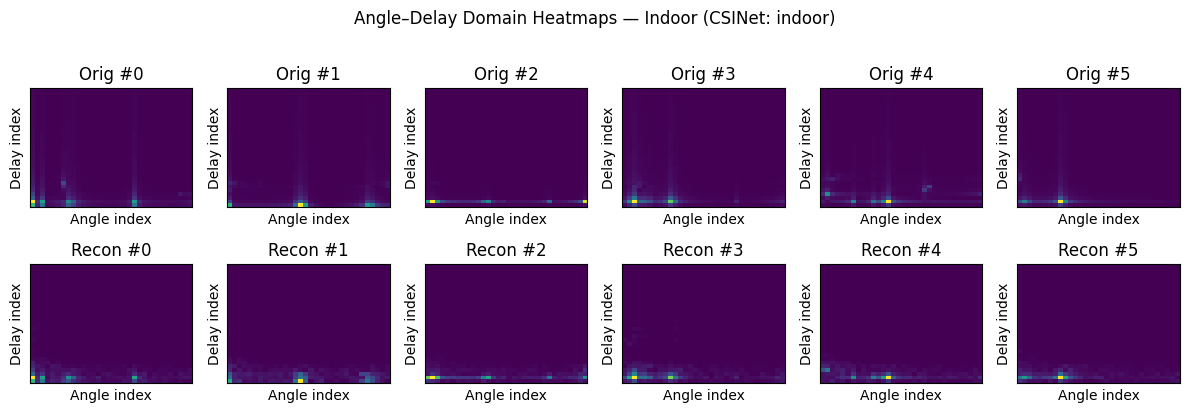

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_indoor.png

[EVAL] CSINet baseline
       model_type   = indoor
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_indoor.pt
[RESULT] NMSE (angle–delay) = 4.74 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386212 -7.965990
indoor+outdoor     -11.583845 -8.006620
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


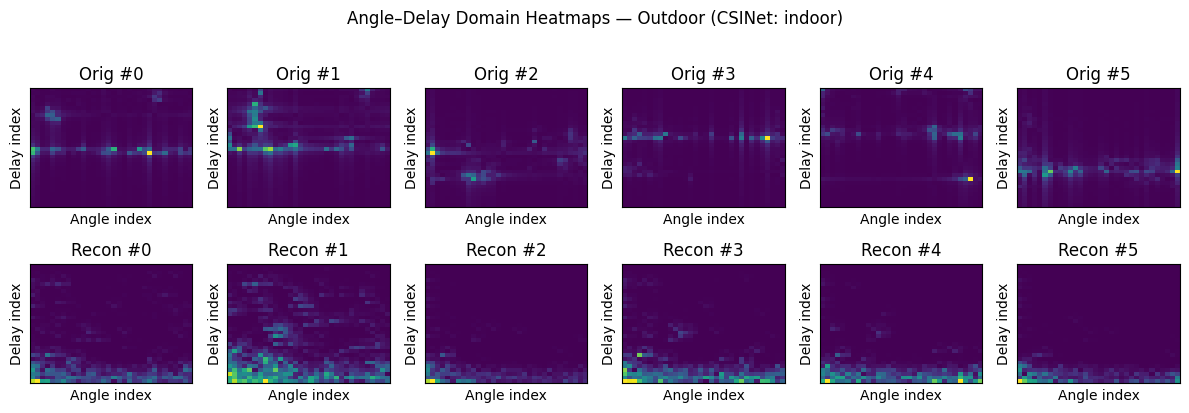

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_indoor.png

[EVAL] CSINet baseline
       model_type   = outdoor
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_outdoor.pt
[RESULT] NMSE (angle–delay) = 0.39 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965990
indoor+outdoor     -11.583845 -8.006620
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


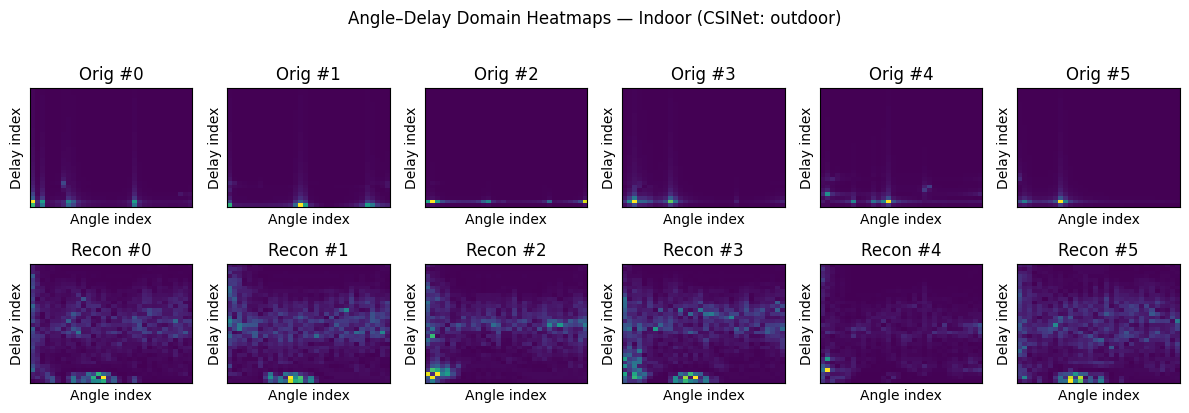

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_outdoor.png

[EVAL] CSINet baseline
       model_type   = outdoor
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_outdoor.pt
[RESULT] NMSE (angle–delay) = -7.97 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583845 -8.006620
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


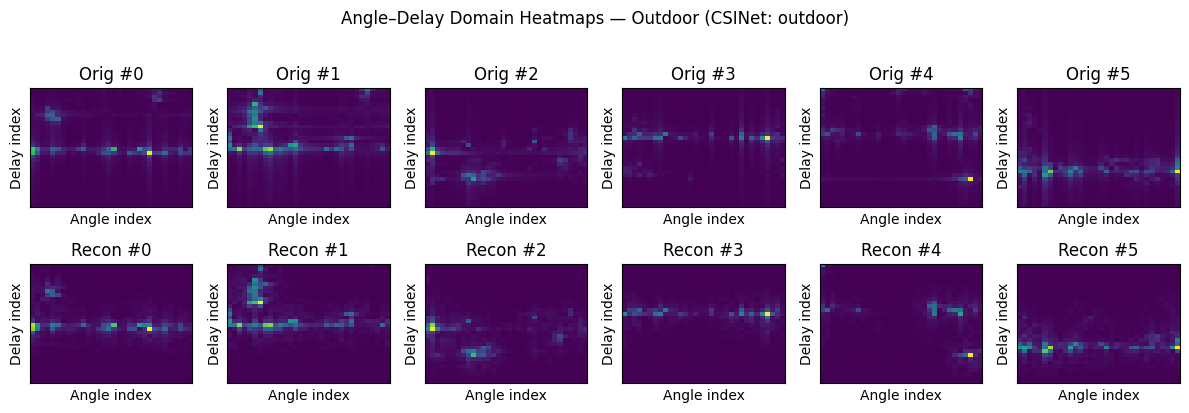

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_outdoor.png

[EVAL] CSINet baseline
       model_type   = indoor+outdoor
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_indoor+outdoor.pt
[RESULT] NMSE (angle–delay) = -11.58 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006620
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


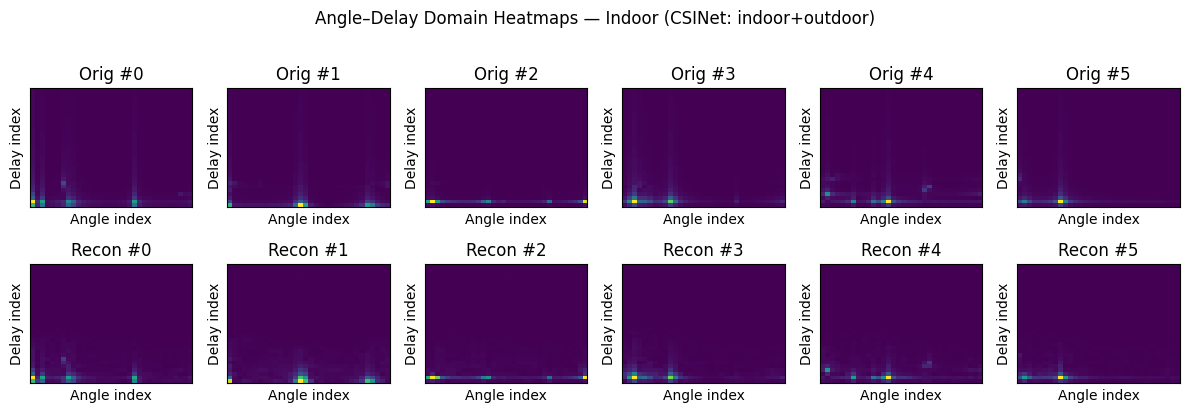

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_indoor+outdoor.png

[EVAL] CSINet baseline
       model_type   = indoor+outdoor
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_indoor+outdoor.pt
[RESULT] NMSE (angle–delay) = -8.01 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840462 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


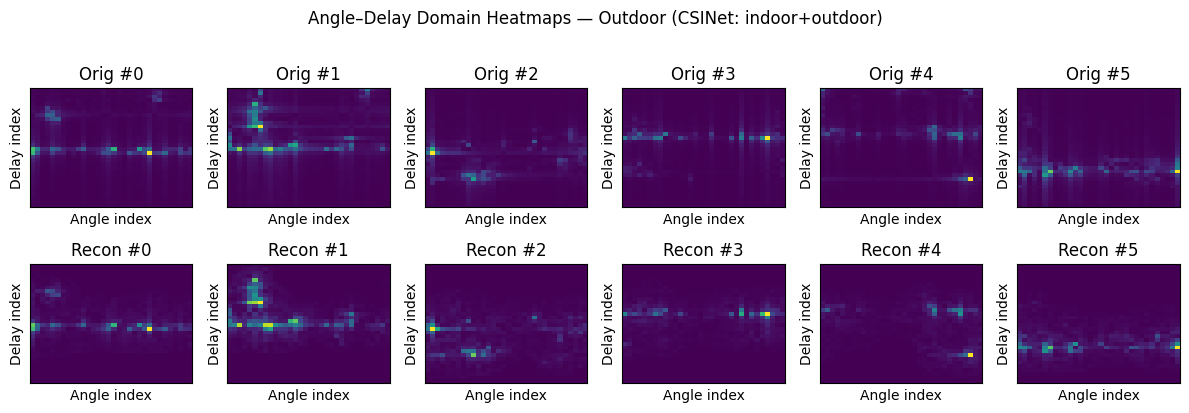

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_indoor+outdoor.png

[EVAL] CSINet baseline
       model_type   = finetune_in2out
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_finetune_in2out.pt
[RESULT] NMSE (angle–delay) = 3.84 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


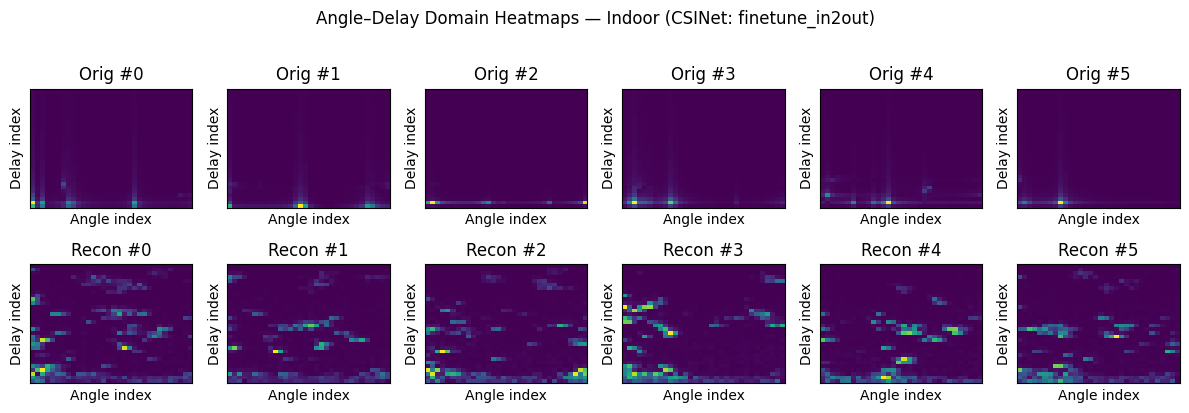

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_finetune_in2out.png

[EVAL] CSINet baseline
       model_type   = finetune_in2out
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_finetune_in2out.pt
[RESULT] NMSE (angle–delay) = -3.42 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


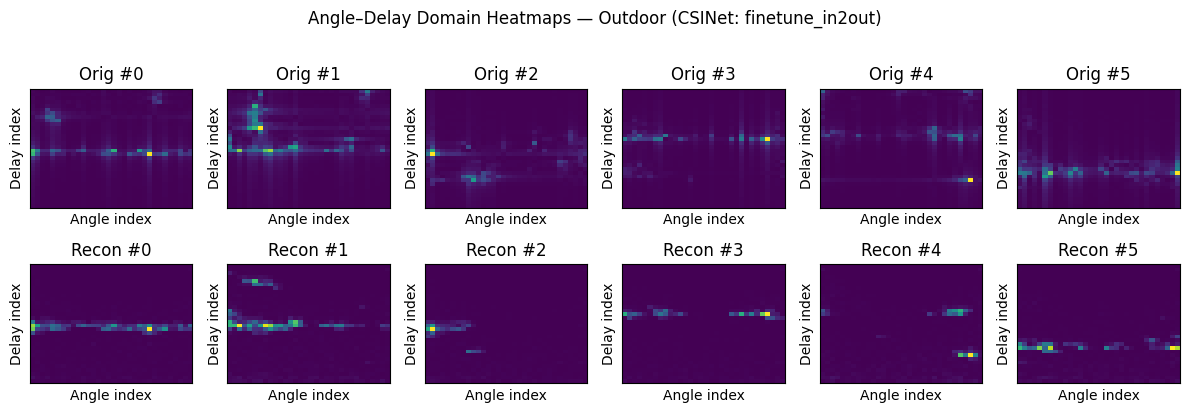

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_finetune_in2out.png

[EVAL] CSINet baseline
       model_type   = finetune_out2in
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_finetune_out2in.pt
[RESULT] NMSE (angle–delay) = -14.41 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


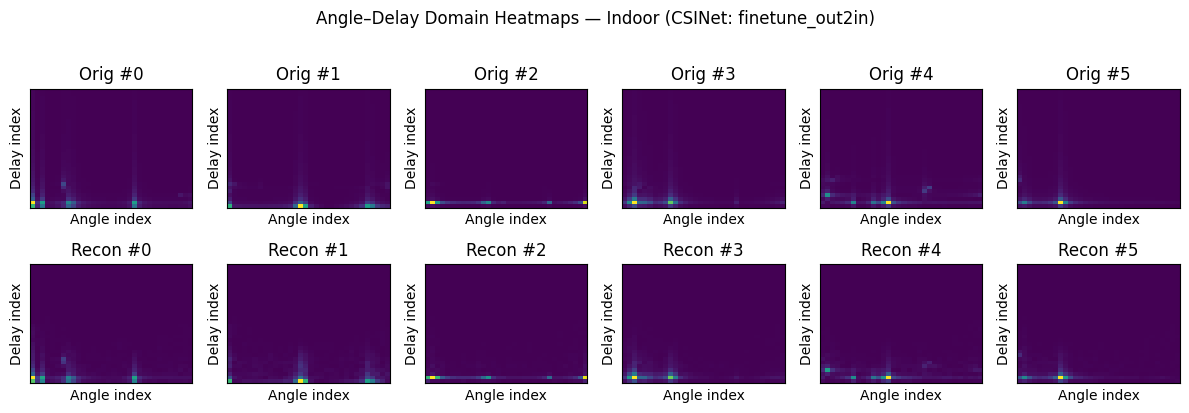

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_finetune_out2in.png

[EVAL] CSINet baseline
       model_type   = finetune_out2in
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_finetune_out2in.pt
[RESULT] NMSE (angle–delay) = 4.63 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464286 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


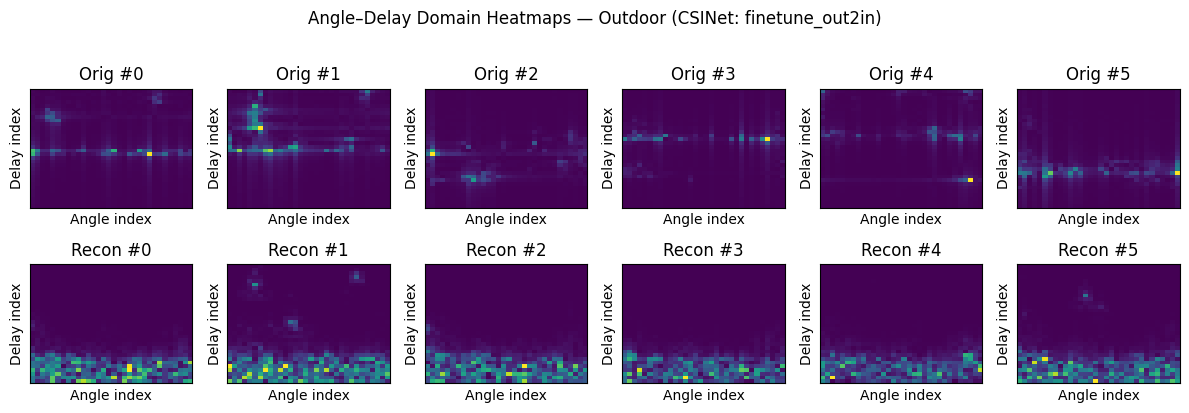

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_finetune_out2in.png

[EVAL] CSINet baseline
       model_type   = replay_in2out
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_replay_in2out.pt
[RESULT] NMSE (angle–delay) = -6.46 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523214
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


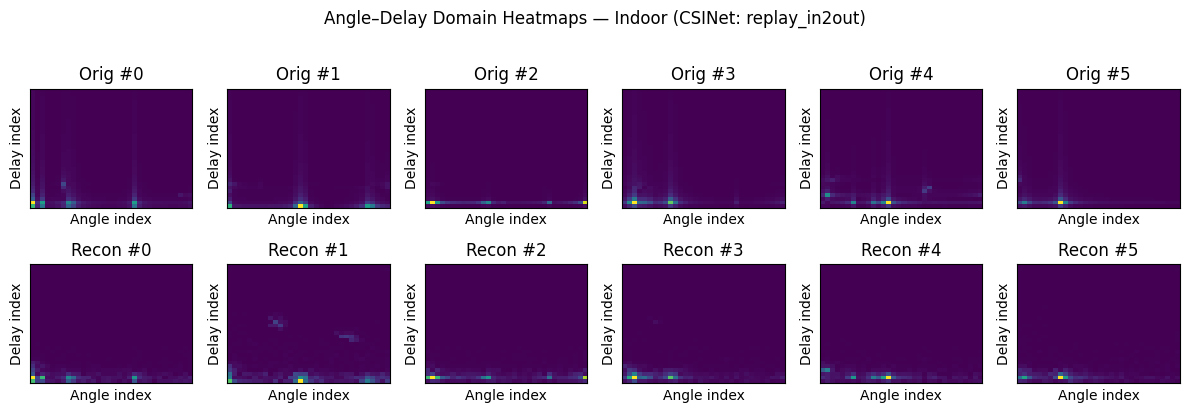

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_replay_in2out.png

[EVAL] CSINet baseline
       model_type   = replay_in2out
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_replay_in2out.pt
[RESULT] NMSE (angle–delay) = -2.52 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243614 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


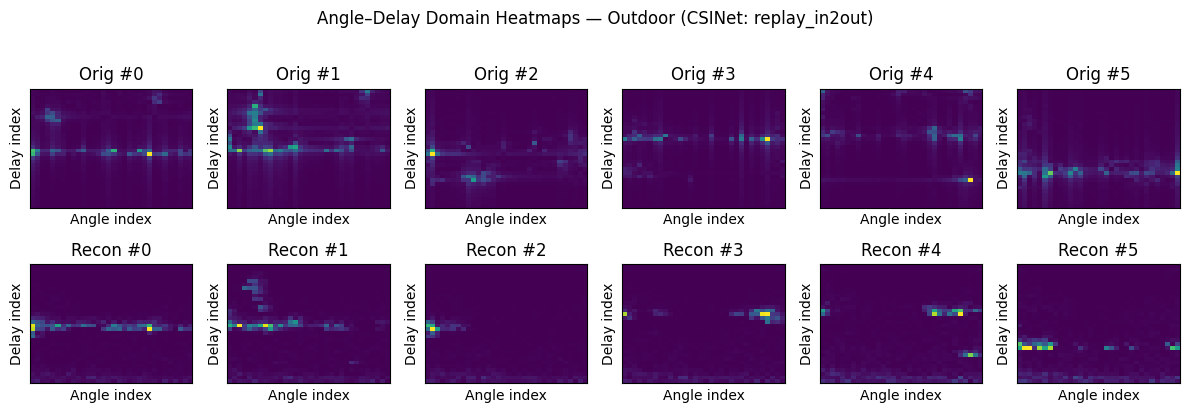

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_replay_in2out.png

[EVAL] CSINet baseline
       model_type   = replay_out2in
       scenario     = indoor
Loaded indoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_replay_out2in.pt
[RESULT] NMSE (angle–delay) = -8.24 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201040
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


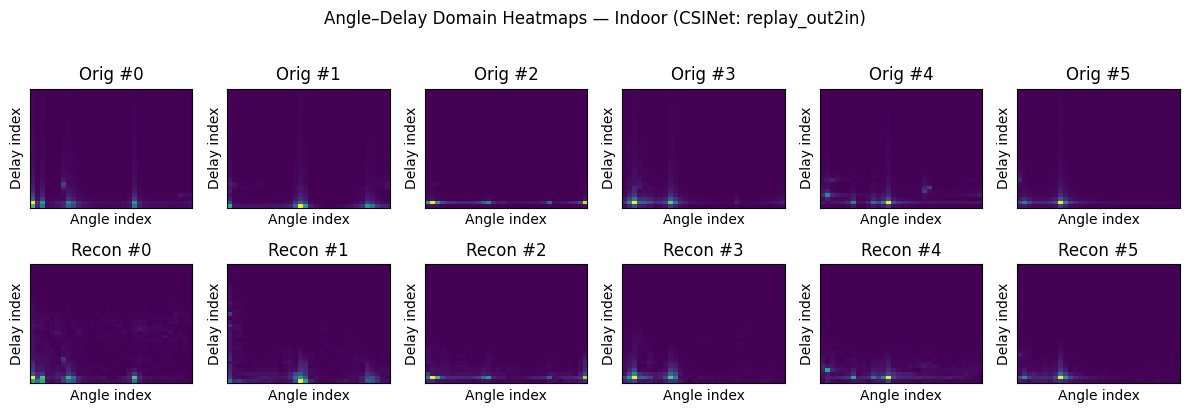

[PLOT] Saved heatmaps to heatmaps_indoor_csinet_replay_out2in.png

[EVAL] CSINet baseline
       model_type   = replay_out2in
       scenario     = outdoor
Loaded outdoor test data: (20000, 2, 32, 32)
[Load] checkpoint: checkpoints\csinet_best_replay_out2in.pt
[RESULT] NMSE (angle–delay) = -6.20 dB
[CSV] Updated:
                       Indoor   Outdoor
indoor              -7.438569  4.737638
outdoor              0.386208 -7.965989
indoor+outdoor     -11.583848 -8.006621
finetune_in2out      3.840464 -3.417659
finetune_out2in    -14.413857  4.631210
replay_in2out       -6.464285 -2.523215
replay_out2in       -8.243590 -6.201051
domainaware_in2out  -9.039465 -4.504227
domainaware_out2in  -6.404637 -8.173368


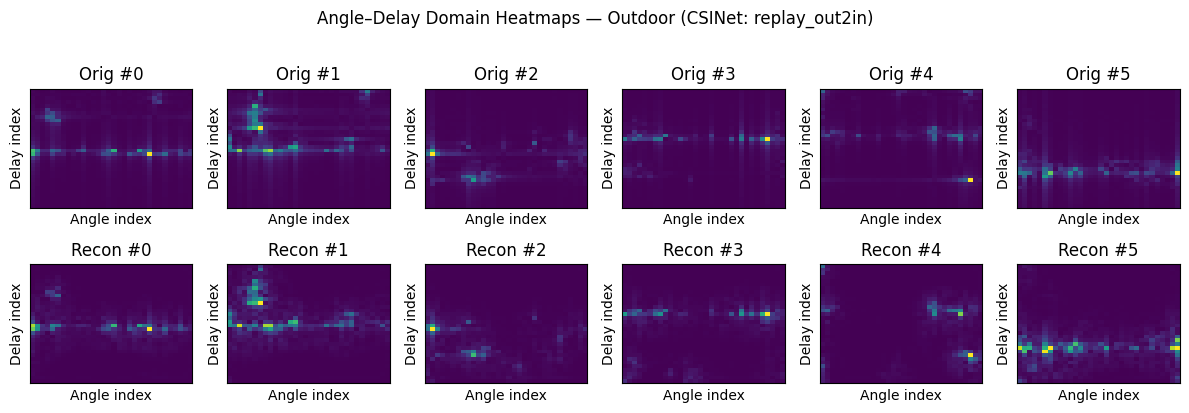

[PLOT] Saved heatmaps to heatmaps_outdoor_csinet_replay_out2in.png

All CSINet baseline evaluations finished.


In [6]:
# ============================================================
# 3. RUN ALL CSINet BASELINE EVALUATIONS
# ============================================================

for model_type in MODEL_TYPES:
    for scenario_type in SCENARIO_TYPES:
        eval_csinet(model_type, scenario_type)

print("\nAll CSINet baseline evaluations finished.")